# 修改config.json ，设置分类个数，我们这里设置num_labels = 22 表示22个类别分类，即"num_labels": 22

In [1]:
import argparse
import logging
import os
import random
import time
import numpy as np
from six.moves import urllib
import torch
import sys
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers.data.processors.glue import glue_convert_examples_to_features as convert_examples_to_features
from transformers.data.processors.utils import DataProcessor, InputExample
from sklearn.preprocessing import LabelEncoder
import pickle
import pandas as pd
from tqdm.auto import tqdm
from tqdm import trange
import warnings

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available() > 0:
        torch.cuda.manual_seed_all(args.seed)
def download_and_extract(filepath, save_dir):
    """根据给定的URL地址下载文件
    Parameter:
        filepath: list 文件的URL路径地址
        save_dir: str  保存路径
    Return:
        None
    """
    for url, index in zip(filepath, range(len(filepath))):
        filename = url.split('/')[-1]
        print('\n\adownload file %s now...'%filename)
        save_path = os.path.join(save_dir, filename)
        urllib.request.urlretrieve(url, save_path)
        sys.stdout.write('\r>> Downloading %.1f%%' % (float(index + 1) / float(len(filepath)) * 100.0))
        sys.stdout.flush()
    print('\nSuccessfully downloaded')

def download_and_extract1(filepath,savedir):
    #引用 requests文件
    import requests
    f=requests.get(filepath)
    #下载文件
    filename = filepath.split('/')[-1]
    print('\n\adownload file %s now...'%filename)
    with open(os.path.join(save_dir, filename),"wb") as code:
         code.write(f.content)

class TextDataProcessor(DataProcessor):
    def __init__(self,train_csv,dev_csv,label_encoder):
        super().__init__()
        self.train_csv=train_csv
        self.dev_csv=dev_csv
        self.label_encoder=label_encoder
        self._read_csv()
        self.id_list=None
        
    """Processor for the Book classification data set."""
    def _read_csv(self):
        from sklearn.model_selection import train_test_split
        df=pd.read_csv(self.train_csv)
        pkl_file = open(self.label_encoder, 'rb')
        le_labels = pickle.load(pkl_file) 
        pkl_file.close()
        del df['id']
        df.dropna(subset=['category'],inplace=True)
        df.dropna(thresh=2,inplace=True)
        df['category'] = le_labels.transform(df['category'])
        df.fillna(value='', inplace=True)
        data=df.values
        X,Y=data[:,:-1],data[:,-1]
        self.labels=set(Y)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, Y,test_size=0.2, random_state=0,stratify=Y)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["sentence"].numpy().decode("utf-8"),
            None,
            str(tensor_dict["label"].numpy()),
        )
    def get_train_examples(self):
        """See base class."""
        # return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")
        return self._create_examples(self.x_train,self.y_train, "train")

    def get_dev_examples(self):
        """See base class."""
        df=pd.read_csv(self.dev_csv)
        df.fillna(value='', inplace=True)
        data=df.values
        self.id_list=data[:,-1]
        return self._create_examples(data[:,:-1],np.ones(data[:,-1].shape), "dev")

    def get_test_examples(self):
        """See base class."""
        return self._create_examples(self.x_test,self.y_test, "test")

    def get_labels(self):
        """See base class."""
        return self.labels
    
    def get_dev_ids(self):
        return self.id_list

    def _create_examples(self, X,Y, set_type):
        """Creates examples for the training and dev/test sets."""
        examples = []
        for (i, x) in enumerate(X):
            guid = "%s-%s" % (set_type, i)
            text_a = x[0]+'。'+x[1]
            text_b=None#x[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=Y[i]))
        return examples

def load_and_cache_examples(args, processor, tokenizer, set_type):
    # Load data features from cache or dataset file
    assert set_type in ['train','dev','test']
    if set_type == 'train':
        print("Creating features from dataset file at {}".format(args.train_csv))
        examples = (
            processor.get_train_examples()
        )
    if set_type == 'dev':
        print("Creating features from dataset file at {}".format(args.dev_csv))
        examples = (
            processor.get_dev_examples()
        )
    if set_type == 'test':
        print("Creating features from dataset file at {}".format(args.train_csv))
        examples = (
            processor.get_test_examples()
        )
    features = convert_examples_to_features(
        examples,  # 原始数据
        tokenizer,  #
        label_list=label_list,
        max_length=args.max_seq_length,  # 设置每个batch 最大句子长度
        output_mode='classification' # 设置分类标记
        #max_length=args.max_seq_length,  # 设置每个batch 最大句子长度
        #pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
        #pad_token_segment_id=0,  # bert 分类设置0
        #mask_padding_with_zero=True  # the attention mask will be filled by ``1``
    )
    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def train(model, data_loader, criterion, optimizer):
    epoch_acc = 0.
    epoch_loss = 0.
    total_batch = 0
    model.train()
    #bar = tqdm(data_loader,desc='    batch',ncols=80,ascii=True)
    for batch in data_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, token_type_ids, labels = batch
        # 预测
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)[0]
        # 计算loss和acc
        loss = criterion(outputs, labels)
        _, y = torch.max(outputs, dim=1)
        acc = (y == labels).float().mean()
        if total_batch % 100 == 0:
            print('Iter_batch[{}/{}]:'.format(total_batch, len(data_loader)),
                  'Train Loss: ', "%.3f" % loss.item(), 'Train Acc:', "%.3f" % acc.item())
        '''
        if total_batch % 100 == 0:
            bar.set_postfix(loss='%.3f'%loss.item(), Acc='%.3f'%acc.item())
        '''
        # 计算批次下总的acc和loss
        epoch_acc += acc.item()  # 当前批次准确率
        epoch_loss += loss.item()  # 当前批次loss
        # 剃度下降
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step()  # Update learning rate schedule
        model.zero_grad()
        total_batch += 1
        # break
    return epoch_acc / len(data_loader), epoch_loss / len(data_loader)


def evaluate(model, data_loader, criterion):
    epoch_acc = 0.
    epoch_loss = 0.
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, token_type_ids, labels = batch
            # 预测
            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)[0]
            # 计算loss和acc
            loss = criterion(outputs, labels)
            _, y = torch.max(outputs, dim=1)
            acc = (y == labels).float().mean()
            # 计算批次下总的acc和loss
            epoch_acc += acc.item()  # 当前批次准确率
            epoch_loss += loss.item()  # 当前批次loss
    return epoch_acc / len(data_loader), epoch_loss / len(data_loader)

import torch.nn.functional as F
from torch.autograd import Variable
class FocalLoss(nn.Module):
    r"""
        This criterion is a implemenation of Focal Loss, which is proposed in 
        Focal Loss for Dense Object Detection.

            Loss(x, class) = - \alpha (1-softmax(x)[class])^gamma \log(softmax(x)[class])

        The losses are averaged across observations for each minibatch.

        Args:
            alpha(1D Tensor, Variable) : the scalar factor for this criterion
            gamma(float, double) : gamma > 0; reduces the relative loss for well-classiﬁed examples (p > .5), 
                                   putting more focus on hard, misclassiﬁed examples
            size_average(bool): By default, the losses are averaged over observations for each minibatch.
                                However, if the field size_average is set to False, the losses are
                                instead summed for each minibatch.


    """
    def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            if isinstance(alpha, Variable):
                self.alpha = alpha
            else:
                self.alpha = Variable(alpha)
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average

    def forward(self, inputs, targets):
        N = inputs.size(0)
        C = inputs.size(1)
        P = F.softmax(inputs)
        class_mask = inputs.data.new(N, C).fill_(0)
        class_mask = Variable(class_mask)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.)
        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]
        probs = (P*class_mask).sum(1).view(-1,1)
        log_p = probs.log()
        batch_loss = -alpha*(torch.pow((1-probs), self.gamma))*log_p 
        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        return loss
    
warnings.filterwarnings('ignore')
logger = logging.getLogger(__name__)
# 初始化参数
parser = argparse.ArgumentParser()
args = parser.parse_args(args=[])  # 在jupyter notebook中，args不为空

#########################################################################
#                               update                                  #
#_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_#
args.train_csv = "dataset/Summary-train.csv"
args.dev_csv = "dataset/validation.csv"
#find out pretrained model file at https://huggingface.co/models
args.pretrain_files=["https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-pytorch_model.bin",
                     "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt",
                     "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-config.json"]

args.pretrain_model='bert-base-chinese'
args.model_type = "bert"
args.task_name = "BookClassification"
args.output_dir = "./outputs"
args.max_seq_length = 64
args.batch_size = 64
args.n_epochs=6
args.lr = 5e-5
#########################################################################

args.label_encoder=args.output_dir+'/category_encoder.pkl'
args.save_model=args.output_dir+'/'+args.model_type.split('/')[-1]+'_model.pt'
args.pretrain_path=os.path.join(args.output_dir,args.pretrain_model)
args.do_train = True
args.do_eval = True
args.warmup_steps = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device
args.seed = 1234

set_seed(args)  # Added here for reproductibility
if not os.path.exists(args.output_dir):
    os.makedirs(args.output_dir)
if not os.path.exists(args.label_encoder):
    le = LabelEncoder()
    args.labels= set(le.fit_transform(pd.read_csv(args.train_csv)['category']))
    #exporting the departure encoder
    output = open(args.label_encoder, 'wb')
    pickle.dump(le, output)
    output.close()
    print('categories:',len(args.labels))

#if there isn't local pretrained model file,need to dowmload them
if not os.path.exists(args.pretrain_path):
    os.makedirs(args.pretrain_path)
    download_and_extract(args.pretrain_files,args.pretrain_path)
elif len(os.listdir(args.pretrain_path))<3:
    download_and_extract(args.pretrain_files,args.pretrain_path)


categories: 22

download file bert-base-chinese-pytorch_model.bin now...
>> Downloading 33.3%
download file bert-base-chinese-vocab.txt now...
>> Downloading 66.7%
download file bert-base-chinese-config.json now...
>> Downloading 100.0%
Successfully downloaded


In [2]:

# 1. 定义数据处理器
processor = TextDataProcessor(args.train_csv,args.dev_csv,args.label_encoder)
args.label_list = processor.get_labels()
label_list = processor.get_labels()
num_labels = len(args.label_list)
print('label: ', args.label_list)
print('-_' * 30)
print('\aLoading Tokenizer','.'*10)
tokenizer = BertTokenizer.from_pretrained( os.path.join(args.pretrain_path, 'bert-base-chinese-vocab.txt') )
print('\aLoading train dataset','.'*10)
train_dataset = load_and_cache_examples(args, processor, tokenizer, 'train')
print('\aLoading test dataset','.'*10)
test_dataset = load_and_cache_examples(args, processor, tokenizer, 'test')
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

N_EPOCHS = args.n_epochs
t_total = len(train_dataloader) // N_EPOCHS
# 4. 模型定义
print('\aLoading pretraining model','.'*10)
model = BertForSequenceClassification.from_pretrained(
    os.path.join(args.pretrain_path, 'bert-base-chinese-pytorch_model.bin'),
    config=os.path.join(args.pretrain_path, 'bert-base-chinese-config.json'),num_labels=len(args.label_list))
#model = BertForSequenceClassification.from_pretrained('pytorch_model.bin',
#    config= 'config.json',num_labels=len(args.label_list),catch_dir='catch')

model.to(device)
# 梯度更新算法AdamW
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = AdamW(optimizer_grouped_parameters, lr=args.lr,
                  correct_bias=False)  
# loss_func
criterion = nn.CrossEntropyLoss()
print('\aLoading done!')

label:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
Loading Tokenizer ..........
Loading train dataset ..........
Creating features from dataset file at dataset/Summary-train.csv
Loading test dataset ..........
Creating features from dataset file at dataset/Summary-train.csv
Loading pretraining model ..........


Some weights of the model checkpoint at ./outputs\bert-base-chinese\bert-base-chinese-pytorch_model.bin were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

Loading done!


In [3]:

# 5. 模型训练
#print('模型训练开始： ')
logger.info("***** Running training *****")
logger.info("  train num examples = %d", len(train_dataloader))
#logger.info("  dev num examples = %d", len(dev_dataloader))
logger.info("  test num examples = %d", len(test_dataloader))
logger.info("  Num Epochs = %d", args.n_epochs)
best_valid_loss = float('inf')
bar=trange(N_EPOCHS,ncols=80,desc='\aEpoch|train')
for epoch in bar:
    train_acc, train_loss = train(model, train_dataloader, criterion, optimizer)
    val_acc, val_loss = evaluate(model, test_dataloader, criterion)
    if val_loss < best_valid_loss:
        print('loss increasing->')
        best_valid_loss = val_loss
        torch.save(model.state_dict(),args.save_model)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.3f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc * 100:.3f}%')
    time.sleep(0.5)
# evaluate
model.load_state_dict(torch.load(args.save_model))
test_acc, test_loss = evaluate(model, test_dataloader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')


Epoch|train:   0%|                                       | 0/6 [00:00<?, ?it/s]

Iter_batch[0/1286]: Train Loss:  3.363 Train Acc: 0.016
Iter_batch[100/1286]: Train Loss:  0.865 Train Acc: 0.750


Epoch|train:   0%|                                       | 0/6 [00:37<?, ?it/s]


KeyboardInterrupt: 

# the follow code need to be checked for the order of predicted answers

In [ ]:
def submit(args,model, data_loader,submit_csv):
    pkl_file = open(args.label_encoder, 'rb')
    le = pickle.load(pkl_file) 
    pkl_file.close()
    res=[]
    for batch in tqdm(data_loader,desc='predict...'):
        batch = tuple(t.to(args.device) for t in batch)
        input_ids, attention_mask, token_type_ids, labels = batch
        # 预测
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)[0]
        _, y = torch.max(outputs, dim=1)
        res.append(le.inverse_transform(y.data.cpu().numpy()).reshape(-1,1))
    sub=np.vstack(res)
    sub=np.hstack([args.id_list.reshape(-1,1),sub.reshape(-1,1)])
    df=pd.DataFrame(sub,columns=['id','label'])
    df.to_csv(submit_csv,index=0) #,index=0不保存行索引

dev_dataset = load_and_cache_examples(args, processor, tokenizer, 'dev')
dev_dataloader = DataLoader(dev_dataset, batch_size=args.batch_size//16, shuffle=False)
args.id_list=processor.get_dev_ids()
model.load_state_dict(torch.load(args.save_model))
submit(args,model, dev_dataloader,args.output_dir+'/submission.csv')

In [ ]:
def predict_(args,model, train_dataloader,test_dataloader,submit_csv):
    pkl_file = open(args.label_encoder, 'rb')
    le = pickle.load(pkl_file) 
    pkl_file.close()
    res=[]

    for batch in tqdm(train_dataloader,desc='predict...'):
        batch = tuple(t.to(args.device) for t in batch)
        input_ids, attention_mask, token_type_ids, labels = batch
        # 预测
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)[0]
        _, y = torch.max(outputs, dim=1)
        res.extend(le.inverse_transform(y.data.cpu().numpy()))


    for batch in tqdm(test_dataloader,desc='predict...'):
        batch = tuple(t.to(args.device) for t in batch)
        input_ids, attention_mask, token_type_ids, labels = batch
        # 预测
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids)[0]
        _, y = torch.max(outputs, dim=1)
        res.extend(le.inverse_transform(y.data.cpu().numpy()))
    df=pd.read_csv(args.train_csv)
    del df['id']
    df.dropna(how='any',inplace=True)
    sub= pd.Series(res, name='predict', index=df.index)
    df= pd.concat([df, sub], axis=1)
    df.to_csv(submit_csv,index=0) #,index=0不保存行索引



model.load_state_dict(torch.load('outputs/bert-model(seq=128,val=0.89).pt'))
predict_(args,model, train_dataloader,test_dataloader,args.output_dir+'/train-predict.csv')

data num 83479
right num 79453
T    548
K    452
I    394
G    365
F    362
C    336
B    308
H    277
D    267
J    156
N    102
O     74
U     69
E     55
X     54
Z     52
P     37
A     36
R     36
V     18
S     15
Q     13
Name: category, dtype: int64
22


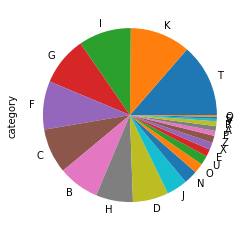

In [2]:
import pandas as pd
df=pd.read_csv('train-predict.csv')
print('data num',len(df))
print('right num',sum(df['category']==df['predict']))
s=df[df['category']!=df['predict']]
count=s['category'].value_counts()
print(count)
count.plot(kind='pie')
print(len(count))

In [ ]:
def load_data(data_csv):
    from sklearn.model_selection import train_test_split
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder
    import numpy as np
    df=pd.read_csv(data_csv,header=0)
    le = LabelEncoder()
    '''
    if 'id' in df.columns:
        del df['id']
    df.dropna(subset=['category'],inplace=True)
    df.dropna(thresh=2,inplace=True)
    df.fillna(value='', inplace=True)
    categories= set(df['category'])
    #exporting the departure encoder
    df.rename(columns={'context':'text','category':'labels'},inplace=True)
    X,Y=df['text'],df['labels']
    '''
    
    df['category'] = le.fit_transform(df['category'])
    
    X,Y=df['title'],df['category']
    x_train, x_test, y_train,y_test = train_test_split(X, Y,test_size=0.2, random_state=0,stratify=Y)
    train_df=pd.concat([x_train,y_train],axis=1)
    test_df=pd.concat([x_test,y_test],axis=1)
    return train_df,test_df
train_df,eval_df=load_data('data/v3.csv')
print(train_df.shape,eval_df.shape)
print(train_df.values[0])
train_df.to_csv('data/split-train-title.csv',index=0)
eval_df.to_csv('data/split-test-title.csv',index=0)